In [1]:
# Notebook: Exploratory Data Analysis - MCPA 911
# Author: Thomas Purk
# Date: 2025-03-21
# Reference: https://www.kaggle.com/datasets/mchirico/montcoalert
# Reference: https://www.kaggle.com/datasets/thomaspurk/emergency-911-calls-mcpa

# Exploratory Data Analysis (EDA)

The purpose of this EDA steps is to build an understanding of the data set by...
- identifying features that may be more important that others,
- reviewing summary statistics,
- visualizing that data as charts or graphs,
- and indentifying any additional data preprocessing steps.

This notebook is part of an ML demonstation project. More information about the simulated project scenario and previous steps can be view in the GitHub.com repository [README.me](https://github.com/thomaspurk/ml-demo-911/blob/main/README.md)

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/emergency-911-calls-mcpa/911.csv


In [23]:
# Notebook Step up steps

import scipy

# Prevent Pandas and other warnings from displaying above outputcells, improve readability
import warnings
warnings.filterwarnings('ignore')

# Load visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Load the data 
df_in_path = '/kaggle/input/emergency-911-calls-mcpa/911.csv'
df_out_path = '/kaggle/working/911-processed.csv'
df_911 = pd.read_csv(df_in_path)
df_911.info() # validate

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649696 entries, 0 to 649695
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   twp           649696 non-null  object
 1   e             649696 non-null  int64 
 2   twp_type      649696 non-null  object
 3   road_type     649696 non-null  object
 4   serivce_type  649696 non-null  object
 5   serivce_desc  649696 non-null  object
 6   month         649696 non-null  int64 
 7   day_of_week   649696 non-null  int64 
 8   day_night     649696 non-null  object
dtypes: int64(3), object(6)
memory usage: 44.6+ MB


In [24]:
# correct spelling errors in column names
df_911.rename(columns={'serivce_type': 'service_type', 'serivce_desc': 'service_desc'}, inplace=True)
df_911.info() # validate

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649696 entries, 0 to 649695
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   twp           649696 non-null  object
 1   e             649696 non-null  int64 
 2   twp_type      649696 non-null  object
 3   road_type     649696 non-null  object
 4   service_type  649696 non-null  object
 5   service_desc  649696 non-null  object
 6   month         649696 non-null  int64 
 7   day_of_week   649696 non-null  int64 
 8   day_night     649696 non-null  object
dtypes: int64(3), object(6)
memory usage: 44.6+ MB


In [25]:
# Notebook Functions

# Need way to test correlation hypoteses for categorical values
def cramers_v(index, columns):
    '''Calculate Cramér's V statistic for categorical-categorical association

    Parameters:
        index (pandas series): Values to group by in the rows.
        columns (pandas series or list): Values to group by in the columns.

    Returns:
        float: The result of the Cramér's V computation

    Interpreting the Output:
    - Chi-Square p-value < 0.05 → Suggests a significant relationship.
    - When n > 5,000, nearly all p-values will be close to 0, even for weak relationships.
        - Use Cramér’s V instead
    - Cramér’s V 
        - closer to 1 → Stronger association;
        - closer to 0 means weak or no correlation.

    References:
        - https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V
        - https://medium.com/@manindersingh120996/understanding-categorical-correlations-with-chi-square-test-and-cramers-v-a54fe153b1d6
        - ChatGPT
        - Google AI Overview
        - SciPy documentation
    '''

    # Create the cross tabulations for the two columns
    cross_table = pd.crosstab(
        index=index,
        columns=columns
    )

    # Compute the independence test statistics
    chi2, p, dof, expected = scipy.stats.chi2_contingency(cross_table)
    # total observations
    n = cross_table.sum().sum()
    # compute Phi coefficient squared
    phi2 = chi2 / n
    # r -> number of rows, k -> number of columns
    r, k = cross_table.shape
    # Compute Cramér's V
    V = np.sqrt(phi2 / min(r - 1, k - 1))
    return V

def create_cramers_v_matrix(df):
    ''' Compute Cramér's V for all categorical variable pairs.

    Parametes:
        df (dataframe): A dataframe of categorical values.

    Returns:
        dataframe: A correlation matrix
    
    '''
    
    categorical_columns = df.columns
    # Track the values of each combo in a matrix
    cramers_v_matrix = pd.DataFrame(
        index=categorical_columns, 
        columns=categorical_columns
    )

    # Iterate over the column combos
    for col1 in categorical_columns:
        for col2 in categorical_columns:
            if col1 == col2:
                cramers_v_matrix.loc[col1, col2] = 1.0  # Self-correlation
            else:
                cramers_v_matrix.loc[col1, col2] = cramers_v(df_911[col1], df_911[col2])
    
    # Convert to numeric for better visualization
    cramers_v_matrix = cramers_v_matrix.astype(float)

    return cramers_v_matrix

### The Objectives Definition statement asks the analysis to attempt 3 predictions
1. Given a call's time and location, what most likely service required?
2. Given a call's service and location, what is the most likely day of week?
3. Given a call's service, location, and day of week, what is the most likely shift?

Text(0.5, 1.0, 'Count Plot of Service Descriptions')

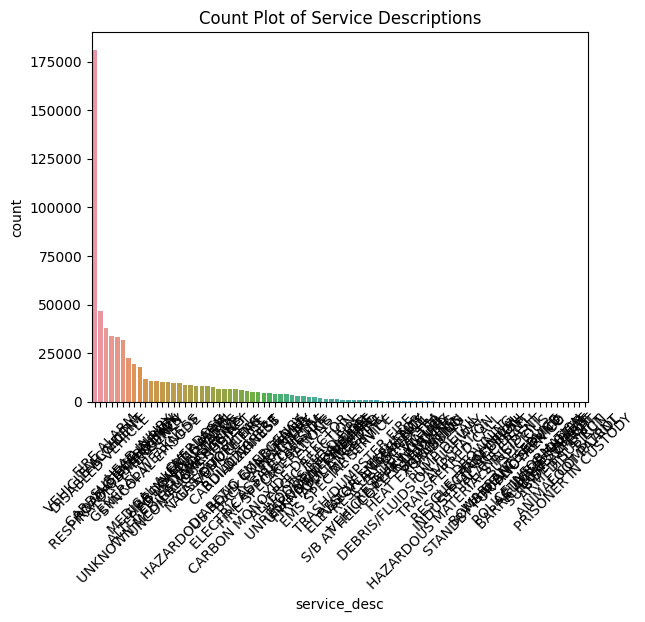

In [26]:
# Count distribution of service_desc
sns.countplot(
    data=df_911,
    x='service_desc',
    order=df_911['service_desc'].value_counts().index
)

plt.xticks(rotation=45)

# Add title
plt.title('Count Plot of Service Descriptions')

In [27]:
# Plot shows a single item with a very large value, what is it?
df_911['service_desc'].value_counts(sort=True, ascending=False)

service_desc
VEHICLE ACCIDENT         181034
DISABLED VEHICLE          46671
FIRE ALARM                37844
FALL VICTIM               33737
RESPIRATORY EMERGENCY     33411
                          ...  
ARMED SUBJECT                 2
ANIMAL COMPLAINT              1
PRISONER IN CUSTODY           1
HIT + RUN                     1
FOOT PATROL                   1
Name: count, Length: 88, dtype: int64

Text(0.5, 1.0, 'Count Plot of Day of Week')

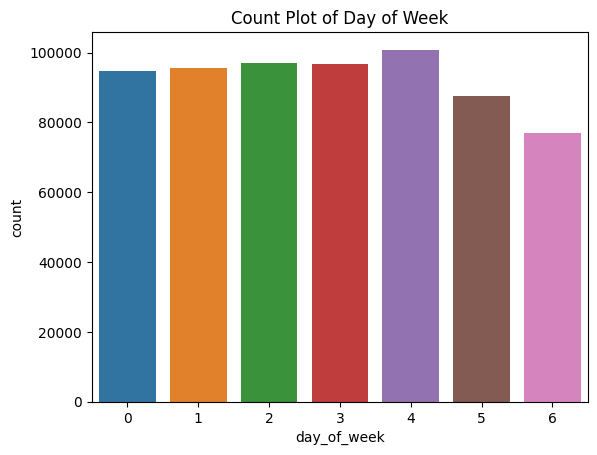

In [28]:
# Count distribution of day_of_week
sns.countplot(
    data=df_911,
    x='day_of_week'
)

# Add title
plt.title('Count Plot of Day of Week')

Text(0.5, 1.0, 'Count Plot of Month')

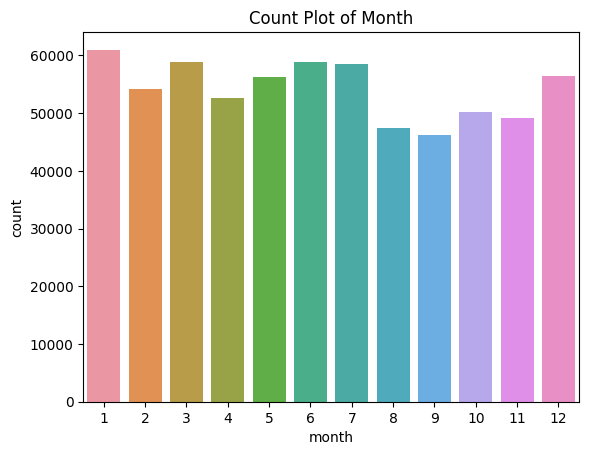

In [29]:
# Count distribution of month
sns.countplot(
    data=df_911,
    x='month'
)

# Add title
plt.title('Count Plot of Month')

Text(0.5, 1.0, 'Count Plot of Day or Night')

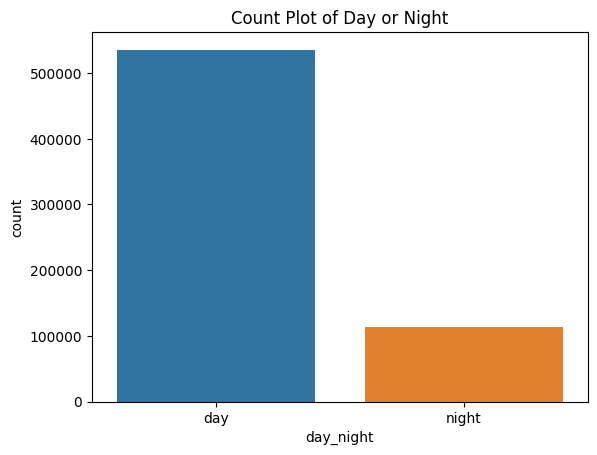

In [30]:
# Count distribution of day_night
sns.countplot(
    data=df_911,
    x='day_night'
)

# Add title
plt.title('Count Plot of Day or Night')

Text(0.5, 1.0, 'Count Plot of Township Type')

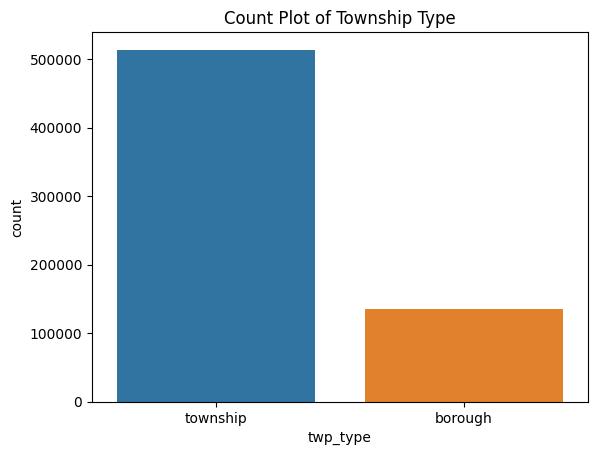

In [31]:
# Count distribution of twp_type
sns.countplot(
    data=df_911,
    x='twp_type'
)

# Add title
plt.title('Count Plot of Township Type')

Text(0.5, 1.0, 'Count Plot of Township')

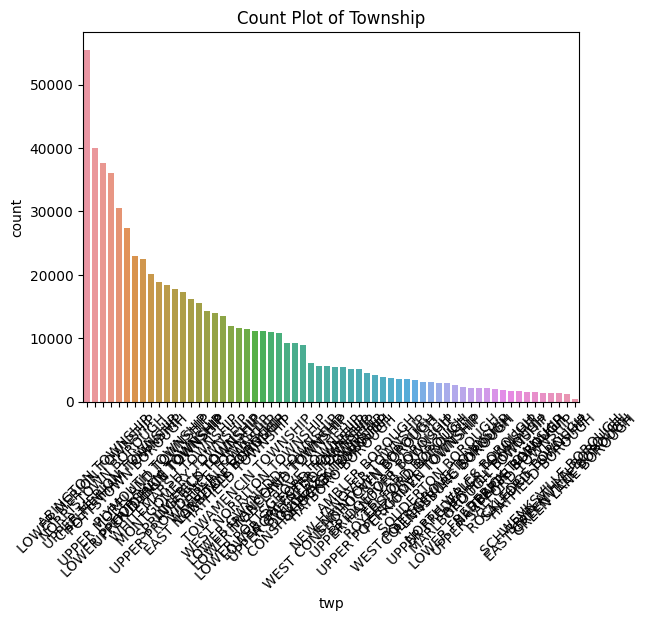

In [32]:
# Count distribution of twp
sns.countplot(
    data=df_911,
    x='twp',
    order=df_911['twp'].value_counts().index
)

plt.xticks(rotation=45)
# Add title
plt.title('Count Plot of Township')

In [33]:
# Plot shows a single item with a very large value, what is it?
df_911['twp'].value_counts(sort=True, ascending=False)

twp
LOWER MERION TOWNSHIP      55490
ABINGTON TOWNSHIP          39947
NORRISTOWN BOROUGH         37633
UPPER MERION TOWNSHIP      36010
CHELTENHAM TOWNSHIP        30574
                           ...  
HATFIELD BOROUGH            1370
SCHWENKSVILLE BOROUGH       1337
EAST GREENVILLE BOROUGH     1316
BRYN ATHYN BOROUGH          1254
GREEN LANE BOROUGH           385
Name: count, Length: 62, dtype: int64

Text(0.5, 1.0, 'Count Plot of Service Type')

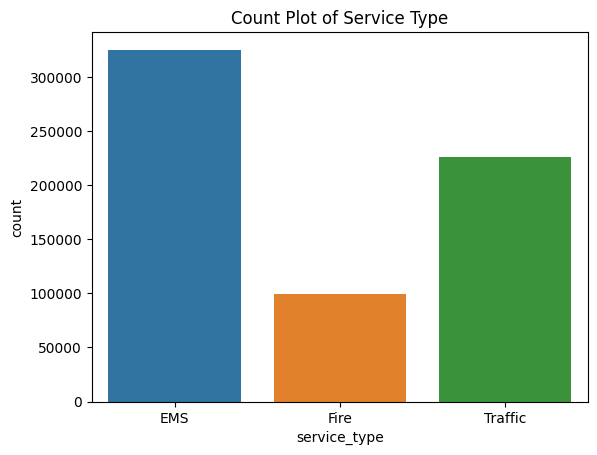

In [34]:
# Count distribution of service_type
sns.countplot(
    data=df_911,
    x='service_type'
)

# Add title
plt.title('Count Plot of Service Type')

Text(0.5, 1.0, 'Count Plot of Road Type')

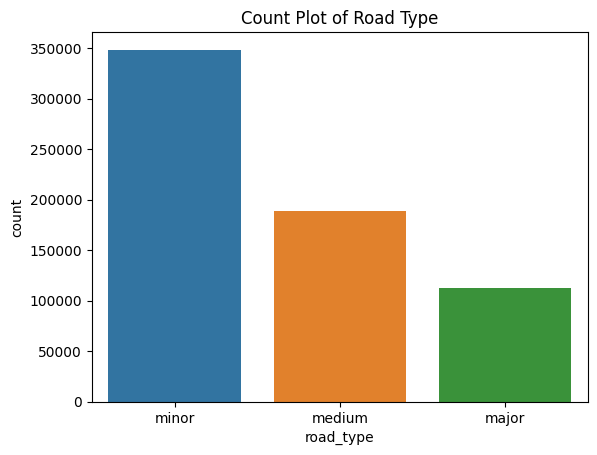

In [35]:
# Count distribution of road_type
sns.countplot(
    data=df_911,
    x='road_type'
)

# Add title
plt.title('Count Plot of Road Type')

Cramér's V Correlation Matrix:
               service_type       twp  twp_type  road_type  service_desc  \
service_type      1.000000  0.164119  0.110449   0.136632      0.901925   
twp               0.164119  1.000000  1.000000   0.422108      0.052260   
twp_type          0.110449  1.000000  1.000000   0.183135      0.164609   
road_type         0.136632  0.422108  0.183135   1.000000      0.161544   
service_desc      0.901925  0.052260  0.164609   0.161544      1.000000   
month             0.025999  0.014942  0.012452   0.009374      0.036646   
day_of_week       0.044487  0.019154  0.015874   0.010875      0.035705   
day_night         0.107292  0.060742  0.043183   0.035270      0.165790   

                 month  day_of_week  day_night  
service_type  0.025999     0.044487   0.107292  
twp           0.014942     0.019154   0.060742  
twp_type      0.012452     0.015874   0.043183  
road_type     0.009374     0.010875   0.035270  
service_desc  0.036646     0.035705   0.165790 

Text(0.5, 1.0, "Cramér's V Correlation Matrix - Categorical Values")

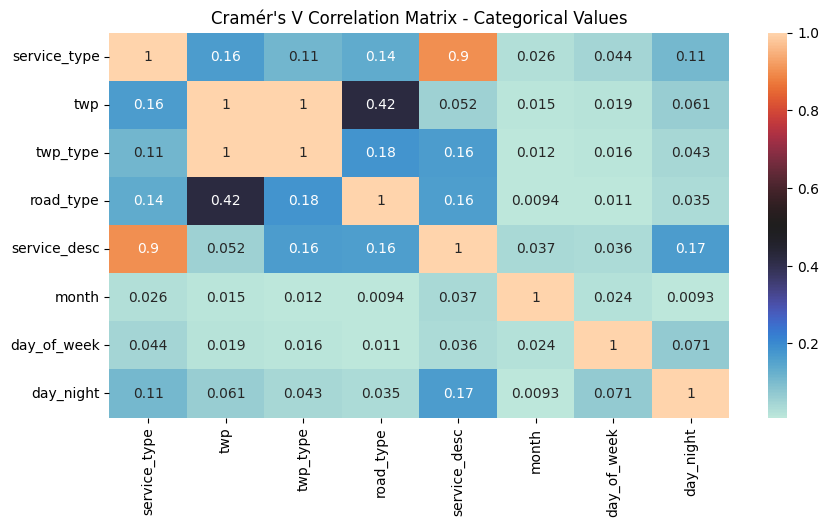

In [36]:
# Which feature are most strongly correlated to service_type?
# Note: service type might be most helpful in deciding on vechicles to purchase
# Note: service description might be most helpful in deciding on which staff to hire

#list(plt.colormaps)

# ['twp', 'e', 'twp_type', 'road_type', 'service_type', 'service_desc', 'month', 'day_of_week', 'day_night']

# Create a subset of columns to report
sub_df = df_911[['service_type', 'twp','twp_type', 'road_type', 'service_desc', 'month', 'day_of_week', 'day_night']]
cramers_v_matrix = create_cramers_v_matrix(sub_df)
print("Cramér's V Correlation Matrix:\n", cramers_v_matrix)

plt.figure(figsize=(10,5))
sns.heatmap(
    data=cramers_v_matrix,
    annot=True,
    cmap='icefire'
)

# Add title
plt.title("Cramér's V Correlation Matrix - Categorical Values")

In [37]:
# It looks like month and day_of_week are not strongly connected to service_desc, 
# but day_night has some relationship to service_desc and service_type

In [39]:
# Explore different Combinations which may correlate to service type

#['twp', 'e', 'twp_type', 'road_type', 'service_type', 'service_desc', 'month', 'day_of_week', 'day_night']
cv = cramers_v(
    index=df_911['service_type'],
    columns=[
        df_911['month'], df_911['day_of_week'], df_911['day_night'], df_911['twp'] 
    ]
)
print(f'Month-Day-Day-TWP: {cv}')

cv = cramers_v(
    index=df_911['service_type'],
    columns=[
        df_911['day_of_week'], df_911['day_night'], df_911['twp'] 
    ]
)
print(f'Day-Day-TWP: {cv}')

cv = cramers_v(
    index=df_911['service_type'],
    columns=[
        df_911['day_night'], df_911['twp'] 
    ]
)
print(f'Day-TWP: {cv}')

cv = cramers_v(
    index=df_911['service_type'],
    columns=[
        df_911['month'], df_911['twp'] 
    ]
)
print(f'Month-TWP: {cv}')

Month-Day-Day-TWP: 0.22750450665414082
Day-Day-TWP: 0.18843450863047517
Day-TWP: 0.1795221159818717
Month-TWP: 0.17029671023340961


In [40]:
# Explore different Combinations which may correlate to service desc

#['twp', 'e', 'twp_type', 'road_type', 'service_type', 'service_desc', 'month', 'day_of_week', 'day_night']
cv = cramers_v(
    index=df_911['service_desc'],
    columns=[
        df_911['month'], df_911['day_of_week'], df_911['day_night'], df_911['twp'] 
    ]
)
print(f'Month-Day-Day-TWP: {cv}')

cv = cramers_v(
    index=df_911['service_desc'],
    columns=[
        df_911['day_of_week'], df_911['day_night'], df_911['twp'] 
    ]
)
print(f'Day-Day-TWP: {cv}')

cv = cramers_v(
    index=df_911['service_desc'],
    columns=[
        df_911['day_night'], df_911['twp'] 
    ]
)
print(f'Day-TWP: {cv}')

cv = cramers_v(
    index=df_911['service_desc'],
    columns=[
        df_911['month'], df_911['twp'] 
    ]
)
print(f'Month-TWP: {cv}')

Month-Day-Day-TWP: 0.14913111720418998
Day-Day-TWP: 0.06527007958480145
Day-TWP: 0.05141274213406533
Month-TWP: 0.05956257061450298


<Figure size 1500x500 with 0 Axes>

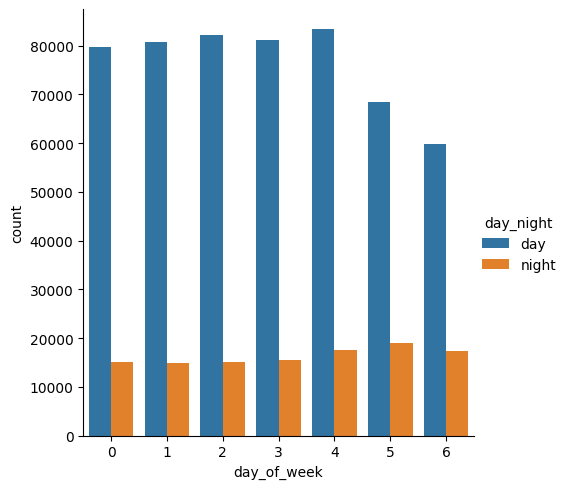

In [41]:
plt.figure(figsize=(15,5))
sns.catplot(
    x='day_of_week', 
    hue='day_night', 
    kind='count', 
    data=df_911
)

## Final Pre-Processing

In [42]:
# NOTE: The combination of month, day_of_week, day_night and twp, gave the strongest correlation to service_desc and service_type
# Drop twp_type and road_type since evidence of strong correlation is not found
# Also road_type is too fine of a geographical identifier. we are looking at regional deployments of vehicles and staff.

# drop the road_type & twp_type columns
df_911.drop('road_type', axis=1, inplace=True)
df_911.drop('twp_type', axis=1, inplace=True)

In [43]:
# Update the file
# After Updating
# 1. Manually Download locally
# 2. Manually Updload to a new version of the Kaggle Dataset


# Check if file exists
if os.path.exists(df_out_path):
    os.remove(df_out_path)
    print(f"File '{df_out_path}' has been deleted.")
else:
    print(f"The file '{df_out_path}' does not exist.")

df_911.to_csv(df_out_path, index=False)

The file '/kaggle/working/911-processed.csv' does not exist.


In [44]:
df_911.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649696 entries, 0 to 649695
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   twp           649696 non-null  object
 1   e             649696 non-null  int64 
 2   service_type  649696 non-null  object
 3   service_desc  649696 non-null  object
 4   month         649696 non-null  int64 
 5   day_of_week   649696 non-null  int64 
 6   day_night     649696 non-null  object
dtypes: int64(3), object(4)
memory usage: 34.7+ MB


In [46]:
# Refactor categorical features a numerical usin one-hot encoding
df_911_encoded = pd.get_dummies(df_911, columns=['twp', 'month', 'day_of_week','day_night'], drop_first=True)

In [48]:
df_911_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649696 entries, 0 to 649695
Data columns (total 82 columns):
 #   Column                         Non-Null Count   Dtype 
---  ------                         --------------   ----- 
 0   e                              649696 non-null  int64 
 1   service_type                   649696 non-null  object
 2   service_desc                   649696 non-null  object
 3   twp_AMBLER BOROUGH             649696 non-null  bool  
 4   twp_BRIDGEPORT BOROUGH         649696 non-null  bool  
 5   twp_BRYN ATHYN BOROUGH         649696 non-null  bool  
 6   twp_CHELTENHAM TOWNSHIP        649696 non-null  bool  
 7   twp_COLLEGEVILLE BOROUGH       649696 non-null  bool  
 8   twp_CONSHOHOCKEN BOROUGH       649696 non-null  bool  
 9   twp_DOUGLASS TOWNSHIP          649696 non-null  bool  
 10  twp_EAST GREENVILLE BOROUGH    649696 non-null  bool  
 11  twp_EAST NORRITON TOWNSHIP     649696 non-null  bool  
 12  twp_FRANCONIA TOWNSHIP         649696 non-nu

In [51]:
# Update the file
# After Updating
# 1. Manually Download locally
# 2. Manually Updload to a new version of the Kaggle Dataset

df_encoded_out_path = '/kaggle/working/911-encoded.csv'
# Check if file exists
if os.path.exists(df_encoded_out_path):
    os.remove(df_encoded_out_path)
    print(f"File '{df_encoded_out_path}' has been deleted.")
else:
    print(f"The file '{df_encoded_out_path}' does not exist.")

df_911.to_csv(df_encoded_out_path, index=False)

The file '/kaggle/working/911-encoded.csv' does not exist.
